In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session9'
sys.path.append(workingdir)

In [3]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import gradcam 
from utils import gradvisualize 

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
classes, trainloader, testloader = datapreparation.load(albumentations=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


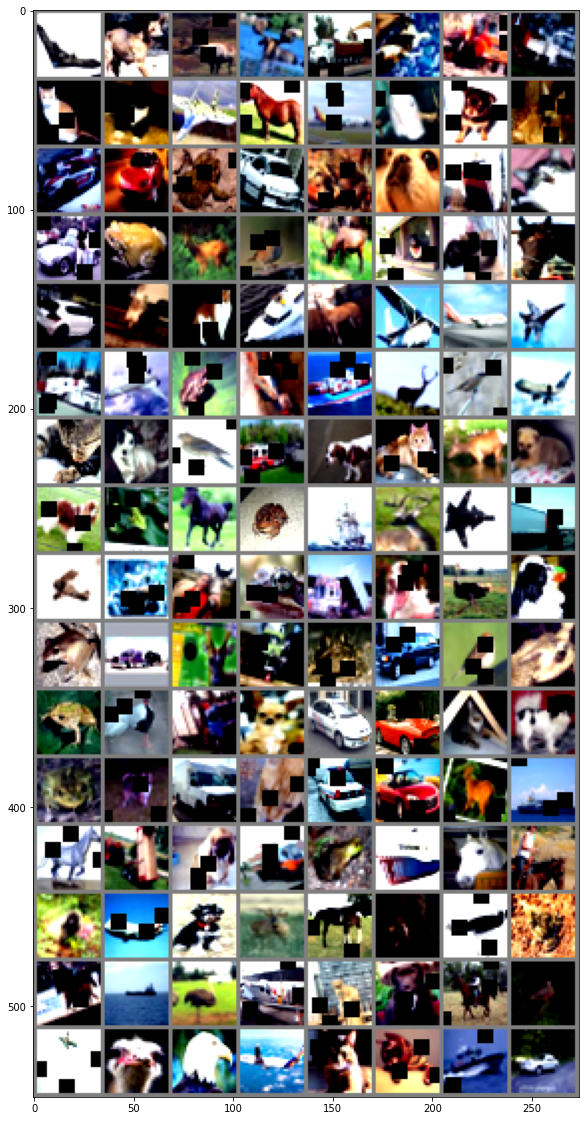

In [5]:
display.show_images(trainloader, classes, 20)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18()
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


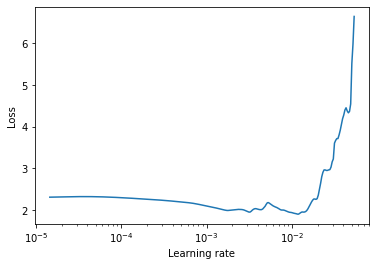

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = lrfinder.LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(trainloader, testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [9]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss,best_lr))

Best Loss: 1.8989669849878286
Best Learning Rate: 0.011955839443468619


In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [11]:
EPOCHS = 20
misclassified_imgs = []
correct_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    training.train_model(model, device, trainloader, optimizer, criterion, epoch)
    misclassified_imgs, correct_imgs = training.test_model(model, device, criterion, testloader, epoch==EPOCHS-1)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.0065484046936035 Batch_id=390 Accuracy=46.94: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 5691/10000 (56.91%)

EPOCH: 2


Loss=0.8740185499191284 Batch_id=390 Accuracy=65.65: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 6393/10000 (63.93%)

EPOCH: 3


Loss=0.5624534487724304 Batch_id=390 Accuracy=72.76: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7647/10000 (76.47%)

EPOCH: 4


Loss=0.6906272172927856 Batch_id=390 Accuracy=77.06: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7776/10000 (77.76%)

EPOCH: 5


Loss=0.6386837959289551 Batch_id=390 Accuracy=79.92: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8069/10000 (80.69%)

EPOCH: 6


Loss=0.5430720448493958 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8275/10000 (82.75%)

EPOCH: 7


Loss=0.4318603575229645 Batch_id=390 Accuracy=83.81: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8523/10000 (85.23%)

EPOCH: 8


Loss=0.4235762655735016 Batch_id=390 Accuracy=84.90: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8397/10000 (83.97%)

EPOCH: 9


Loss=0.37356773018836975 Batch_id=390 Accuracy=86.17: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8435/10000 (84.35%)

EPOCH: 10


Loss=0.42001938819885254 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8367/10000 (83.67%)

EPOCH: 11


Loss=0.3323028087615967 Batch_id=390 Accuracy=87.95: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8579/10000 (85.79%)

EPOCH: 12


Loss=0.34279465675354004 Batch_id=390 Accuracy=88.72: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8506/10000 (85.06%)

EPOCH: 13


Loss=0.4646684527397156 Batch_id=390 Accuracy=89.52: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8591/10000 (85.91%)

EPOCH: 14


Loss=0.31960123777389526 Batch_id=390 Accuracy=90.21: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8661/10000 (86.61%)

EPOCH: 15


Loss=0.5847499370574951 Batch_id=390 Accuracy=90.95: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8622/10000 (86.22%)

EPOCH: 16


Loss=0.14494666457176208 Batch_id=390 Accuracy=91.51: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8774/10000 (87.74%)

EPOCH: 17


Loss=0.28062111139297485 Batch_id=390 Accuracy=91.84: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8794/10000 (87.94%)

EPOCH: 18


Loss=0.20294061303138733 Batch_id=390 Accuracy=92.40: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8764/10000 (87.64%)

EPOCH: 19


Loss=0.18051262199878693 Batch_id=390 Accuracy=92.62: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8844/10000 (88.44%)

EPOCH: 20


Loss=0.12200462818145752 Batch_id=390 Accuracy=93.14: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]



Test set: Average loss: 0.0031, Accuracy: 8785/10000 (87.85%)



GroundTruth:  plane horse   car   dog plane
Predicted:  plane horse   car   dog plane


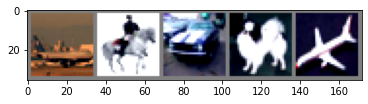

In [12]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [13]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 87 %


In [14]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 88 %
Accuracy of   car : 79 %
Accuracy of  bird : 77 %
Accuracy of   cat : 60 %
Accuracy of  deer : 89 %
Accuracy of   dog : 69 %
Accuracy of  frog : 94 %
Accuracy of horse : 97 %
Accuracy of  ship : 90 %
Accuracy of truck : 100 %


Visualize GradCam

In [15]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [16]:
#len(testloader.dataset)
print(misclassified_imgs[0]["img"])

tensor([[[-1.2590, -1.2590, -1.2749,  ..., -1.2590, -1.2431, -1.1955],
         [-1.2431, -1.2590, -1.2749,  ..., -1.2431, -1.1955, -1.1320],
         [-1.2590, -1.2431, -1.2749,  ..., -1.2272, -1.1479, -1.1161],
         ...,
         [-1.1479, -1.2114, -1.1479,  ..., -1.1955, -1.2114, -1.2114],
         [-1.1637, -1.1796, -1.1479,  ..., -1.1955, -1.1796, -1.2114],
         [-1.1320, -1.1479, -1.1796,  ..., -1.1796, -1.1637, -1.1637]],

        [[-1.4326, -1.4326, -1.4487,  ..., -1.4487, -1.4165, -1.3682],
         [-1.4165, -1.4326, -1.4487,  ..., -1.4165, -1.3682, -1.3038],
         [-1.4487, -1.4165, -1.4487,  ..., -1.4004, -1.3199, -1.2877],
         ...,
         [-1.3199, -1.3843, -1.3199,  ..., -1.3682, -1.3843, -1.3843],
         [-1.3360, -1.3521, -1.3199,  ..., -1.3682, -1.3521, -1.3843],
         [-1.3038, -1.3199, -1.3521,  ..., -1.3521, -1.3360, -1.3360]],

        [[-0.9874, -0.9874, -1.0024,  ..., -0.9874, -0.9724, -0.9274],
         [-0.9724, -0.9874, -1.0024,  ..., -0

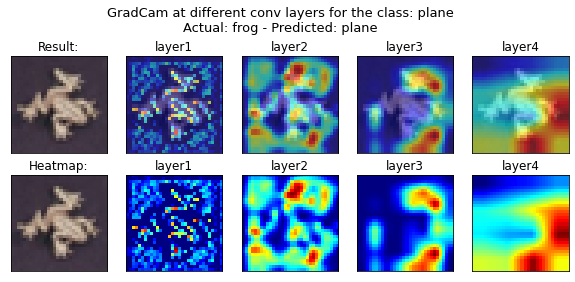

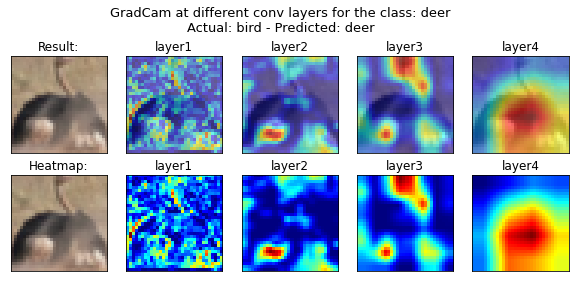

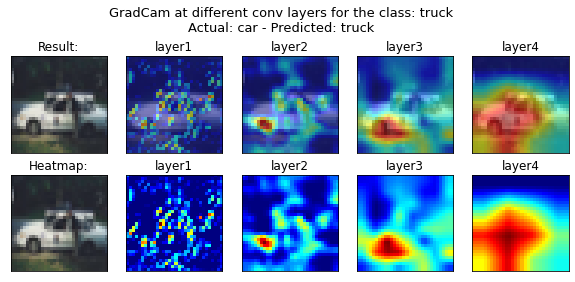

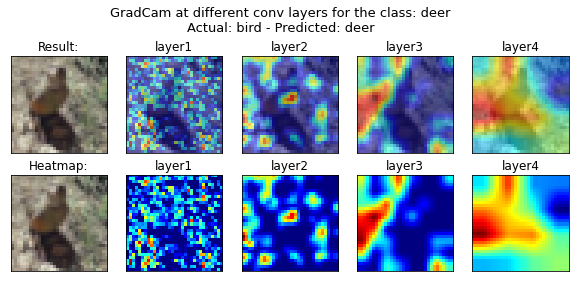

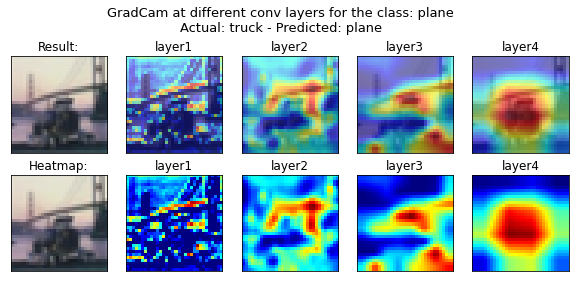

In [17]:
#GradCam for incorrectly classified images

num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")